## Loading Dataset

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import models
import cv2
import numpy as np
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


In [ ]:
train_generator = ImageDataGenerator(rescale=1./255,validation_split=0.3)
#Image data generator rescaled image basically as it is a greyscale image max value will be 255 so we divide by 255
test_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
IMAGE_DIR = "/content/drive/MyDrive/Casting Production /casting_data/casting_data/"#Image directory
IMAGE_SIZE = (300,300)#image size
BATCH_SIZE = 64#batch size 





gen_args = dict(target_size = IMAGE_SIZE,
                color_mode = "grayscale",
                batch_size = BATCH_SIZE,
                class_mode = "binary",
                classes = {"ok_front": 0, "def_front": 1}
                )## All arguments that nee to be apply on data set



train = train_generator.flow_from_directory(
                                        directory = IMAGE_DIR + "train/",
                                        subset='training',
                                        shuffle = True, 
                                        **gen_args
                                        )
validation = train_generator.flow_from_directory(
                                        directory = IMAGE_DIR + "train/",
                                        subset='validation',
                                        shuffle = True, 
                                        **gen_args
                                        )


test = test_generator.flow_from_directory(
                                          directory = IMAGE_DIR+ "test/",
                                          shuffle=False,
                                          **gen_args
                                          )


Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


## Visualize_data


In [ ]:
mapping_class = {0: "ok", 1: "defect"}
mapping_class

{0: 'ok', 1: 'defect'}

In [ ]:
#visualizing first batch of images
def visualizeImageBatch(dataset, title):
    images, labels = next(iter(dataset))
    images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
    fig, axes = plt.subplots(8, 8, figsize=(16,16))

    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        ax.set_title(mapping_class[label], size = 20)

    plt.tight_layout()
    fig.suptitle(title, size = 30, y = 1.05, fontweight = "bold")
    plt.show()
    
    return images

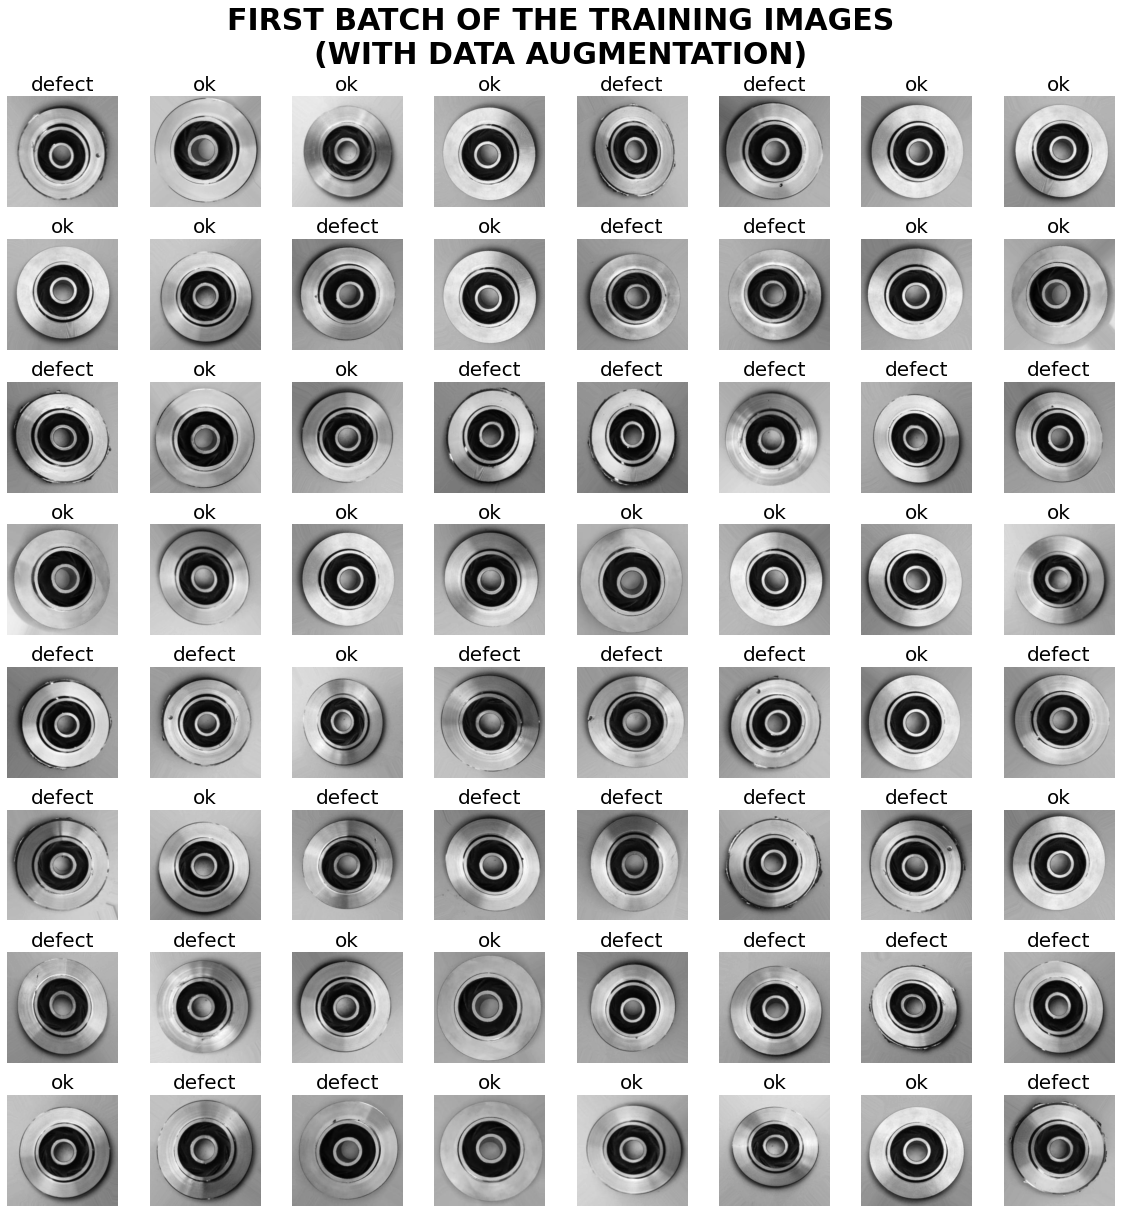

In [ ]:
train_images = visualizeImageBatch(train,
                                   "FIRST BATCH OF THE TRAINING IMAGES\n(WITH DATA AUGMENTATION)")

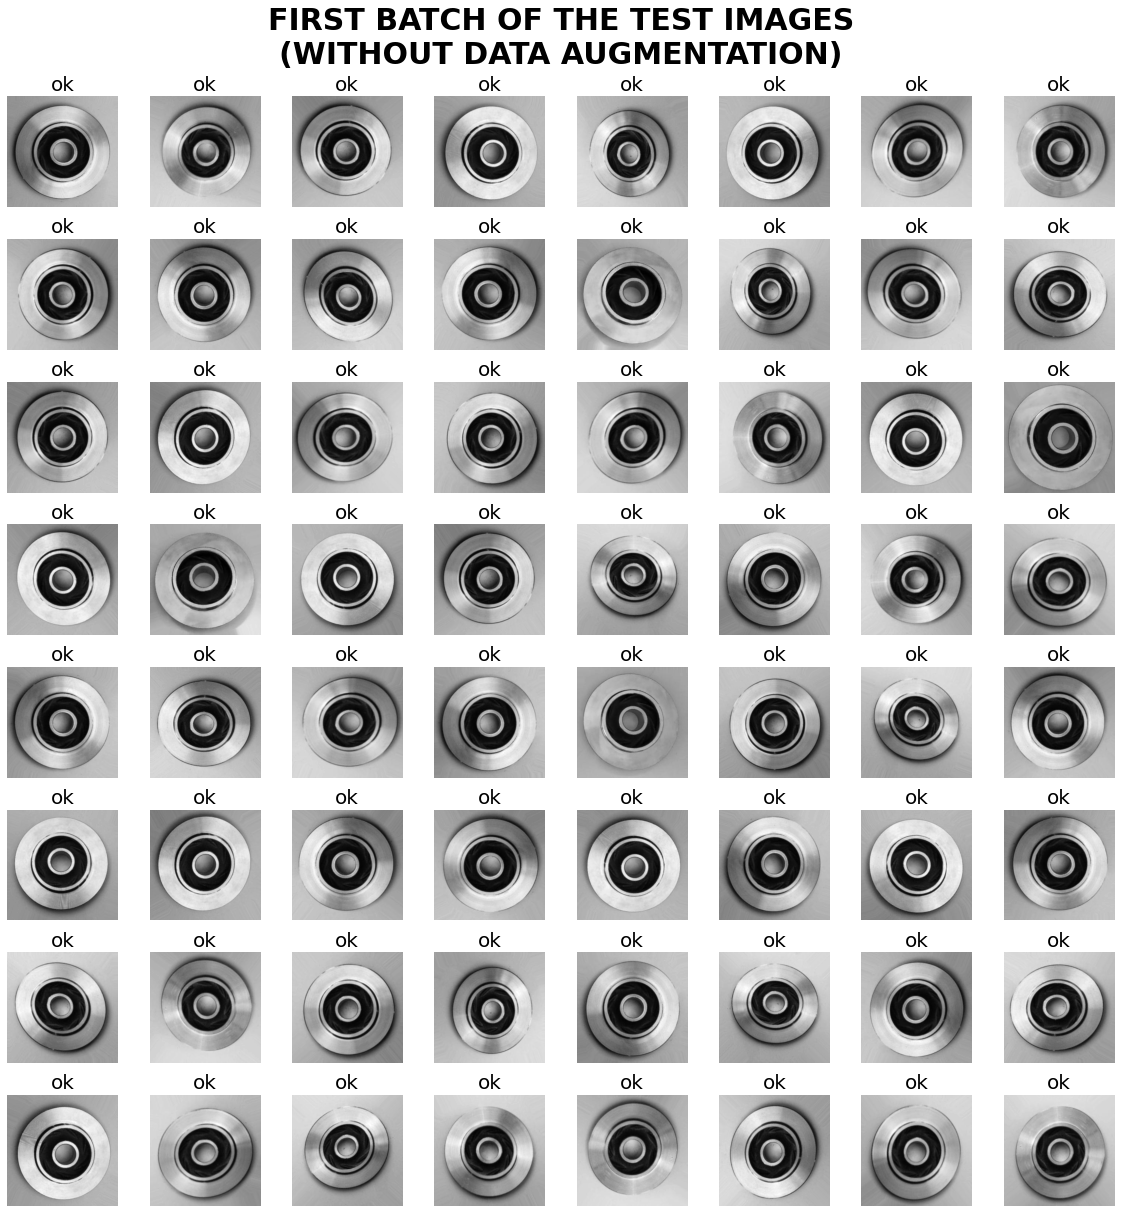

In [ ]:
test_images = visualizeImageBatch(test,
                                  "FIRST BATCH OF THE TEST IMAGES\n(WITHOUT DATA AUGMENTATION)")

## Model

In [ ]:
input_shape=IMAGE_SIZE+(1,)
print(input_shape)

(300, 300, 1)


In [ ]:
#trying to hyperparameter tunning
# from keras.backend import pool2d
# def build_model(hp):  
#   model = keras.Sequential([
#     keras.layers.Conv2D(
#         filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
#         kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
#         strides=2,
#         activation='relu',
#         input_shape=IMAGE_SIZE+(1,)
#     ),
#     keras.layers.MaxPool2D(
#         pool_size = 2,
#         strides = 2
#     ),
#     keras.layers.Conv2D(
#         filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
#         kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
#         strides = 2,
#         activation='relu'
#     ),
#     keras.layers.MaxPool2D(
#         pool_size = 2,
#         strides = 2
#     ),
#     keras.layers.Flatten(),
#     keras.layers.Dense(
#         128,
#         activalion='relu'
#     ),
#     keras.layers.Dense(1, activation='softmax')
#   ])
  
#   model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
  
#   return model

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [ ]:
# model bulding
# basically here I am using CNN model 
#architechture 
# first layer convolution layer with 32 filter of kernel size of 3
                      # |
                      # v
                # maxpooling
                      # |
                      # v
# again another convolution with 64 filter and kernel size of 3
                      # |
                      # v
          # again maxpooling layer
                      # |
                      # v
        # then dense layer of 128
                      # |
                      # v
# last again dense layer of 1 as we want binary out using sigmoid as activation
model = Sequential([
        Conv2D(filters = 32, kernel_size= 3,activation='relu',strides=2, input_shape=IMAGE_SIZE+(1,)),
        MaxPooling2D(pool_size=2,strides=2),
        Conv2D(filters=64,kernel_size=3,strides=2,activation='relu'),
        MaxPooling2D(pool_size=2,strides=2),
        Flatten(),
        Dense(128,activation='relu'),
        Dense(1,activation='sigmoid')
])


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 149, 149, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 20736)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)
#here i used easrly_Stop it willmontior validation loss and check validation score if validation is dropping continuously two time it will stop traini
#

In [ ]:
# from gc import callbacks
train_model = model.fit(
    train,
    validation_data = validation,
    epochs = 30,
    callbacks=[early_stop]
)

Epoch 1/30
73/73 [==============================] - 85s 1s/step - loss: 0.2851 - accuracy: 0.8848 - val_loss: 0.2272 - val_accuracy: 0.9251
Epoch 2/30
73/73 [==============================] - 28s 379ms/step - loss: 0.2413 - accuracy: 0.9057 - val_loss: 0.2616 - val_accuracy: 0.8974
Epoch 3/30
73/73 [==============================] - 28s 381ms/step - loss: 0.1808 - accuracy: 0.9410 - val_loss: 0.1606 - val_accuracy: 0.9452
Epoch 4/30
73/73 [==============================] - 27s 375ms/step - loss: 0.1522 - accuracy: 0.9490 - val_loss: 0.1428 - val_accuracy: 0.9568
Epoch 5/30
73/73 [==============================] - 28s 378ms/step - loss: 0.1172 - accuracy: 0.9625 - val_loss: 0.1233 - val_accuracy: 0.9608
Epoch 6/30
73/73 [==============================] - 28s 379ms/step - loss: 0.1141 - accuracy: 0.9621 - val_loss: 0.1108 - val_accuracy: 0.9603
Epoch 7/30
73/73 [==============================] - 28s 380ms/step - loss: 0.0757 - accuracy: 0.9808 - val_loss: 0.1557 - val_accuracy: 0.9316
Ep

Here I am getting around 99.5% accuract  and 98.9 % accuracy on validation data

In [ ]:

y_pred = model.predict(test)
y_pred = (y_pred >= 0.5).reshape(-1,)

In [ ]:
y_actual = test.classes[test.index_array]

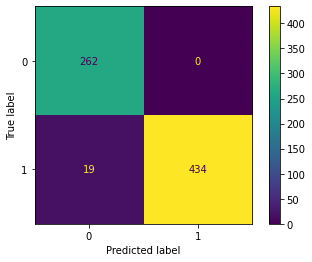

In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_actual, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
#confusion matrix

In [ ]:
model.save('model.h5')
#saving keras model
# I saved this model as model.h5


In [ ]:
model = models.load_model('model.h5')
## Loading model

## Running model on webcam

In [ ]:
video = cv2.VideoCapture(0)

video.set(3,640) # adjust width
video.set(4,480) # adjust height

while True:
    _, frame = video.read()
    cv2.putText(frame, str(prediction), (320, 240), font, 5, (0, 0, 0))#putting prediction of model on frame
    cv2.imshow("Webcam", frame)
    im = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #converting image into grey as we need input in grey only
    
    im = cv2.resize(im,IMAGE_SIZE)#resizing to 300*300
    
#     im = test_generator.
    
    img_array = np.array(im)
    
    img_array = img_array/255##rescaling
    
    img = img_array.reshape((-1,)+IMAGE_SIZE+(1,))#reshaping as per input_size in CNN model
    
#     img = img.data.reshape(n_images,286,384,1)
    
#     img = np.expand_dims(img,axis=0)
    
#     print(img.shape,end="")
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    prediction = int(model.predict(img))##prediction
    
#     print(prediction,end="")
    
    
    key=cv2.waitKey(1)
    if key == ord('q'):
        break

video.release()
cv2.destroyAllWindows()